In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d, make_smoothing_spline

from astropy import units as u

mpl.rc('font', family='serif', size=16)

In [2]:
import jax
import equinox as eqx
from tinygp.helpers import JAXArray

jax.config.update("jax_enable_x64", True)

In [3]:
def dateformat(ax):
    locator   = mpl.dates.AutoDateLocator()
    formatter = mpl.dates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

In [4]:
def histogram_residuals(mu_ss, mu_gp, var_ss, var_gp):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3), sharey=True)
    ax1.hist(mu_ss-mu_gp)
    ax2.hist(var_ss-var_gp)
    ax1.set(xlabel=r'$\mu_{ss} - \mu_{gp}$', )
    ax2.set(xlabel=r'$\sigma^2_{ss} - \sigma^2_{gp}$');
    fig.tight_layout()
    return fig, (ax1, ax2)

In [5]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import expm, solve

key = jax.random.PRNGKey(0)

In [6]:
import tinygp
import smolgp

# Benchmarking

In [7]:
import importlib

import benchmark
importlib.reload(benchmark)
from benchmark import *

In [8]:
np.array([f'{n:.1e}' for n in jnp.logspace(1,7,17)])

array(['1.0e+01', '2.4e+01', '5.6e+01', '1.3e+02', '3.2e+02', '7.5e+02',
       '1.8e+03', '4.2e+03', '1.0e+04', '2.4e+04', '5.6e+04', '1.3e+05',
       '3.2e+05', '7.5e+05', '1.8e+06', '4.2e+06', '1.0e+07'], dtype='<U7')

# Plot layout

In [9]:
# mpl.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
# mpl.rc("text", usetex=True)
# mpl.rcParams["axes.formatter.useoffset"] = False

# plt.rcParams['text.usetex'] = True
# plt.rcParams['lines.markeredgewidth'] = 1.5
# plt.rcParams['lines.markersize'] = 8
# plt.rcParams['lines.markeredgecolor'] = 'k'
# plt.rcParams['lines.linewidth'] = 2

In [10]:
mpl.rc("font", **{"family": "sans serif"})
mpl.rc("text", usetex=False)
mpl.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['text.usetex'] = False
plt.rcParams['lines.markeredgewidth'] = 1.5
plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.markeredgecolor'] = 'k'
plt.rcParams['lines.linewidth'] = 3

In [11]:
def scale_ext(Next, Ns, runtime_arr, ref=-1, power=1):
    runtimes = np.array([rt[0] for rt in runtime_arr])
    cutnan = ~np.isnan(runtimes)
    runtimes = runtimes[cutnan]
    last_runtime = runtimes[ref]
    last_N = np.array(Ns)[cutnan][ref]
    return last_runtime * (Next / last_N)**power

In [32]:
def residuals_plot(Ns, outputs, label='X'):
    val_ssm = jnp.array(outputs['SSM'])
    val_qsm = jnp.array(outputs['QSM'])
    val_gp  = jnp.array(outputs['GP'])

    res_qs_ss = (val_ssm - val_qsm)
    res_qs_gp = (val_gp - val_qsm)
    res_ss_gp = (val_ssm - val_gp)

    fig, rax = plt.subplots(1,1, figsize=(6,2), sharex=True)
    rax.plot(Ns, res_qs_gp, ls='-',  label=f'${label}'+r'_{GP}$ - '+f'${label}'+r'_{QSM}$')
    rax.plot(Ns, res_qs_ss, ls='--', label=f'${label}'+r'_{SSM}$ - '+f'${label}'+r'_{QSM}$')
    rax.plot(Ns, res_ss_gp, ls=':',  label=f'${label}'+r'_{SSM}$ - '+f'${label}'+r'_{GP}$')
    rax.set(xscale='log', xlabel='Number of data points', ylabel='Residual');
    rax.legend(ncol=3, bbox_to_anchor=(0.5, 1), handletextpad=0.1, loc='lower center', fontsize=12);
    rax.set_yscale('symlog', linthresh=1e-16); rax.grid(lw=0.5, zorder=-1)
    rax.set_yticks(symlogticks(-9, -9, linthresh=1e-16, spacing=3))
    return fig, rax

In [33]:
def benchmark_plot(Ns, runtime, memory, labels=None,title=None, savefig=None):
    
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(5,6), sharex=True, 
                                gridspec_kw={'height_ratios':[3,1.5], 'hspace':0.05})
    ax1 = plot_benchmark(Ns, runtime, labels=labels, ax=ax1)# savefig=savefig)
    ax1.legend(loc='upper left')
    ax1.set_title(title)
    ax1.set_ylim(top=1e3);
    # plt.savefig(savefig, dpi=300, bbox_inches='tight');
    # savefig = '/Users/rrubenzahl/Desktop/figures/benchmark_llh.png'
    ax1.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0, numticks=10))
    ax1.yaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=jnp.arange(1, 10)*0.1, numticks=10))
    ax1.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

    ax1.set_xlabel('')
    ax2 = plot_benchmark(Ns, memory,  ax=ax2, scale=False, labels=labels)# savefig=savefig)
    # ax2.legend(loc='upper left')
    ax2.get_legend().remove()
    # ax2.set_yticks([1e3, 1e6, 1e9], labels=['1 kB', '1 MB', '1 GB'])
    ax2.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0, numticks=10))
    ax2.yaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=jnp.arange(1, 10)*0.1, numticks=10))
    ax2.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax2.set_ylabel('Memory [B]');
    ax2.set_xlim(left=Ns[0], right=Ns[-1])
    # ax2.set_ylim(bottom=1e3);
    # ax2.set_ylim(top=1e3);
    if savefig:
        plt.savefig(savefig, dpi=300, bbox_inches='tight');

    return fig, (ax1, ax2)

## Likelihood

In [34]:
llh_filename = 'results/llh_benchmark.pkl'

In [35]:
# Ns, runtime_llh, memory_llh, outputs = benchmark_llh(ssSHO, qsSHO, gp_kernel=gpSHO, 
#                                                      true_kernel=qsSHO, yerr=yerr,
#                                                      n_repeat=5, trace_memory=True,
#                                                      N_N=13, logN_min=1, logN_max=7,
#                                                      gp_cutoff=1e5, 
#                                                     #  ss_cutoff=1e3, qs_cutoff=1e3,
#                                                      ss_cutoff=1e7, qs_cutoff=1e7,
#                                                      )

In [36]:
# save_benchmark_data(llh_filename, Ns, runtime_llh, memory_llh, outputs)

In [37]:
# Ns, runtime_llh, memory_llh, outputs = load_benchmark_data(llh_filename)

In [38]:
import pickle

with open(llh_filename, "rb") as f:
    cpu_data = pickle.load(f)

with open('results/gpu_llh_benchmark.pkl', "rb") as f:
    gpu_data = pickle.load(f)

for d in ['runtime_llh']:
    cpu_data[d]['pSSM'] = gpu_data[d]['pSSM']

Ns, runtime_llh, memory_llh, outputs = cpu_data['Ns'], cpu_data['runtime_llh'], cpu_data['memory_llh'], cpu_data['outputs']

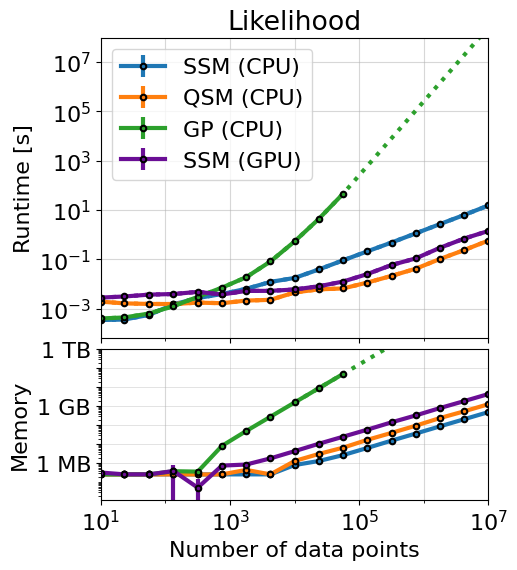

In [39]:
fig, (ax1, ax2) = benchmark_plot(Ns, runtime_llh, memory_llh, title='Likelihood',
                                 labels={"SSM": "SSM (CPU)", 
                                         "QSM": "QSM (CPU)", 
                                         "GP": "GP (CPU)", 
                                         "pSSM": "SSM (GPU)"})
Next = jnp.logspace(6,8,10)
# ax1.plot(Next, scale_ext(Next, Ns, runtime_llh['GP'], ref=-1, power=3), ls=':', color=colors['GP'], label='O(N^3)');
ax1.set_ylim(top=1e8);

Next = jnp.logspace(4,8,10)
ax2.plot(Next, scale_ext(Next, Ns, memory_llh['GP'], ref=-1, power=2), ls=':', color=colors['GP'], label='O(N^2)');
ax2.set_yticks([1e6, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12], labels=['1 MB', '', '', '1 GB', '', '', '1 TB']); ax2.set_ylabel('Memory')
ax2.grid(lw=0.5, zorder=-1, which='major')
ax2.set_ylim(top=1e12);

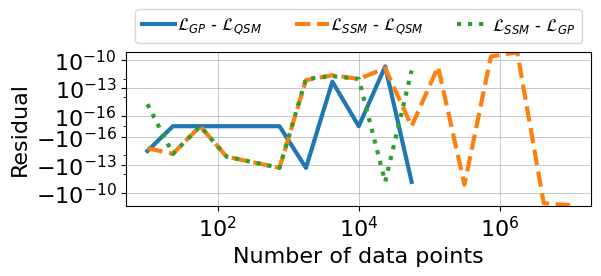

In [40]:
fig, rax = residuals_plot(Ns, outputs, label=r'\mathcal{L}')

## Conditioning at the data points

In [ ]:
cond_filename = 'results/cond_benchmark.pkl'
Ns, runtime_cond, memory_cond, outputs_cond = load_benchmark_data(cond_filename)

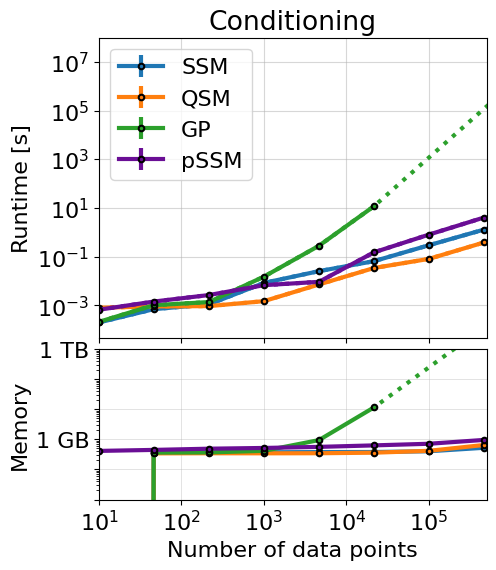

In [ ]:
fig, (ax1, ax2) = benchmark_plot(Ns, runtime_cond, memory_cond, title='Conditioning')
Next = jnp.logspace(4,8,10)
ax1.plot(Next, scale_ext(Next, Ns, runtime_cond['SSM'], ref=-2, power=1), ls=':', color=colors['SSM'], label='O(N)')
ax1.plot(Next, scale_ext(Next, Ns, runtime_cond['QSM'], ref=-2, power=1), ls=':', color=colors['QSM'], label='O(N)')
ax1.set_ylim(top=1e8);

Next = jnp.logspace(4.3,8,10)
ax2.plot(Next, scale_ext(Next, Ns, memory_cond['GP'], ref=5, power=2), ls=':', color=colors['GP'], label='O(N^2)');
ax2.set_yticks([1e6, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12], labels=['1 MB', '', '', '1 GB', '', '', '1 TB']); ax2.set_ylabel('Memory')
ax2.grid(lw=0.5, zorder=-1, which='major')
ax2.set_ylim(bottom=10e6, top=1e12);

ax2.set_xlim(right=5e5);

In [ ]:
outputs_cond['pSSM'][0] / outputs_cond['GP'][0]

Array([[1.60852792, 1.60852884, 1.60852839, 1.60852905, 1.60853021,
        1.60852913, 1.6085282 , 1.60852925, 1.60852809, 1.6085301 ],
       [1.60852859, 1.60852859, 1.60852859, 1.60852859, 1.60852859,
        1.60852859, 1.60852859, 1.60852859, 1.60852859, 1.60852859]],      dtype=float64)

In [ ]:
def getloc(out):
    try:
        mean = out[0]
        return mean[0]
    except:
        return jnp.nan

def getvar(out):
    try:
        var = out[1] - jnp.median(out[1])
        return var[0]
    except:
        return jnp.nan

In [ ]:
means = {name: [getloc(outputs_cond[name][n]) for n in range(len(Ns))] for name in outputs_cond}
vars  = {name: [getvar(outputs_cond[name][n]) for n in range(len(Ns))] for name in outputs_cond}

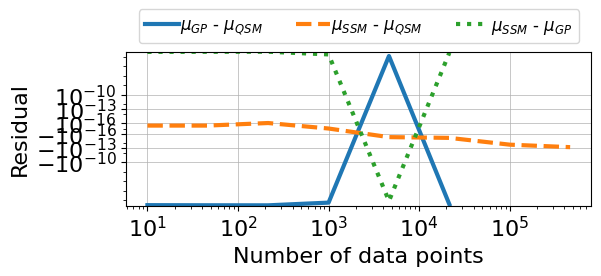

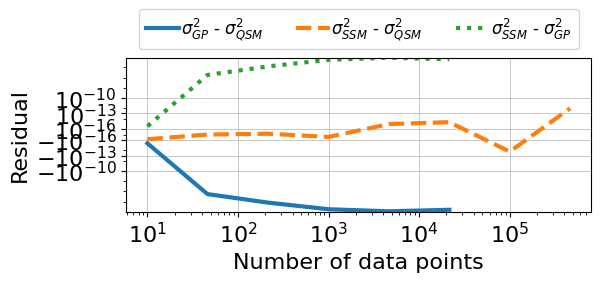

In [ ]:
fig, rax = residuals_plot(Ns, means, label=r'\mu')
fig, rax = residuals_plot(Ns, vars, label=r'\sigma^2')

## In-notebook running

In [ ]:
N = 1000
t_train, y_train = sample_data(N)

## Build GP for given dataset
gp_ss = smolgp.GaussianProcess(ssSHO, t_train, diag=yerr**2)
gp_qs = tinygp.GaussianProcess(qsSHO, t_train, diag=yerr**2)
gp_gp = tinygp.GaussianProcess(gpSHO, t_train, diag=yerr**2)

### method 1/default: `GaussianProcess.condition`

In [ ]:
## Condition on data, returns likelihood and 
## conditioned GP object w/ predictions at data points
llh, condGP = gp_ss.condition(y_train)

In [ ]:
%%timeit -n 10
## Method 1: use gp.condition which also returns the likelihood
llh, condGP = gp_ss.condition(y_train)
## Then the mean and variance can be extracted from the conditioned GP attributes
mu  = condGP.loc #- y_ss
var = condGP.var #- yvar_ss

llh, mu, var

8.16 ms ± 287 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### method 2: `GaussianProcess.predict` with a data array

In [ ]:
## we can also use predict from an unconditioned GP 
## and it will condition it using self.condition
## in which case we need to give predict a time and data array `y`
## but can pass None to X_test to have it use the data coordinates
mu, var = gp_ss.predict(None, y_train, return_var=True)

In [ ]:
%%timeit -n 10
gp_ss.predict(None, y_train)

8.18 ms ± 794 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### benchmark

In [ ]:
import benchmark
importlib.reload(benchmark)
from benchmark import *

In [ ]:
(Ns, outputs), (runtime_ss_cond, runtime_qs_cond, runtime_gp_cond) \
        = benchmark_condition(ssSHO, qsSHO, gpSHO=gpSHO,
                        true_kernel=qsSHO, yerr=yerr,
                        N_N=10, n_repeat=3, 
                        logN_min=1, logN_max=7,
                        ss_cutoff=1e6, qs_cutoff=1e5, gp_cutoff=1e4)

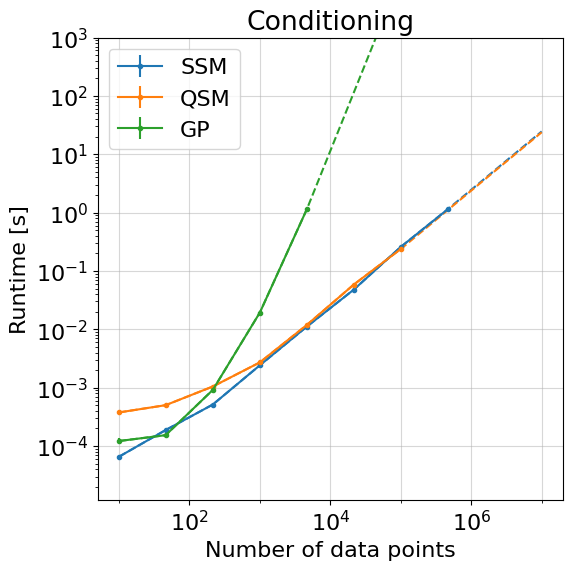

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,6), sharex=True)

savefig = '/Users/rrubenzahl/Desktop/figures/benchmark_condition.png'
ax = plot_benchmark(Ns, runtime_ss_cond, runtime_qs_cond, runtime_gp_cond, 
                    ax=ax, labels=['SSM', 'QSM', 'GP'],)# savefig=savefig)
ax.legend(loc='upper left')
ax.set_title('Conditioning')
ax.set_ylim(top=1e3)
plt.savefig(savefig, dpi=300, bbox_inches='tight')


### Verification of outputs

## Predicting at test points

In [ ]:
## Can use condGP to then make predictions
## useful for speed if making multiple different 
## predictions based on a single conditioned GP
##
## by default just returns the already computed 
# conditioned mean/ar at the data points
mu, var = condGP.predict(return_var=True)

In [ ]:
M = 10000
t_test = jnp.linspace(t.min(), t.max(), M)

In [ ]:
%%timeit -n 10
mu, var = condGP.predict(t_test, return_var=True)
mu.block_until_ready(), var.block_until_ready();

The slowest run took 16.71 times longer than the fastest. This could mean that an intermediate result is being cached.
11.3 ms ± 19.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit -n 10
mu, var = gp_qs.predict(y_train, t_test, return_var=True)
mu.block_until_ready(); var.block_until_ready();

133 ms ± 15.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
_, condGPqs = gp_qs.condition(y_train)

### benchmark

In [ ]:
import benchmark
importlib.reload(benchmark)
from benchmark import *

In [ ]:
(Ns, outputs), (runtime_ss_pred, runtime_qs_pred, runtime_gp_pred) \
        = benchmark_prediction(ssSHO, qsSHO, gpSHO=gpSHO,
                        true_kernel=qsSHO, yerr=yerr,
                        N_M=10, n_repeat=1, 
                        logM_min=1, logM_max=7,
                        ss_cutoff=1e5, qs_cutoff=1e4, gp_cutoff=1e4,
                        N=10000
                        )

NOTE: WERE TIMING PREDICTIONS, NOT INIT+CONDITION, BUT ONLY FOR SSM


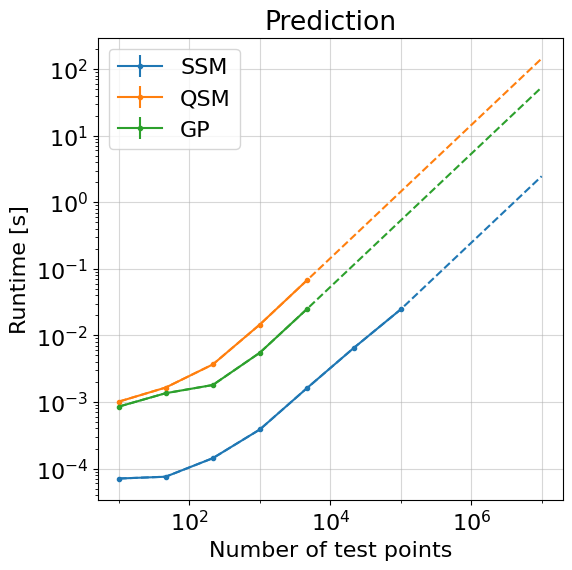

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,6), sharex=True)

savefig = '/Users/rrubenzahl/Desktop/figures/benchmark_predict.png'
ax = plot_benchmark(Ns, runtime_ss_pred, runtime_qs_pred, runtime_gp_pred, 
                    ax=ax, labels=['SSM', 'QSM', 'GP'],
                    powers=[1,1,1])# savefig=savefig)
ax.legend(loc='upper left')
ax.set(title='Prediction', xlabel='Number of test points')
plt.savefig(savefig, dpi=300, bbox_inches='tight')

print('NOTE: WERE TIMING PREDICTIONS, NOT INIT+CONDITION, BUT ONLY FOR SSM')

In [ ]:
# fig, (ax1, ax2) = histogram_residuals(mu_ss, mu_gp, var_ss, var_gp)

### Verification of outputs

# Full benchmarking plot

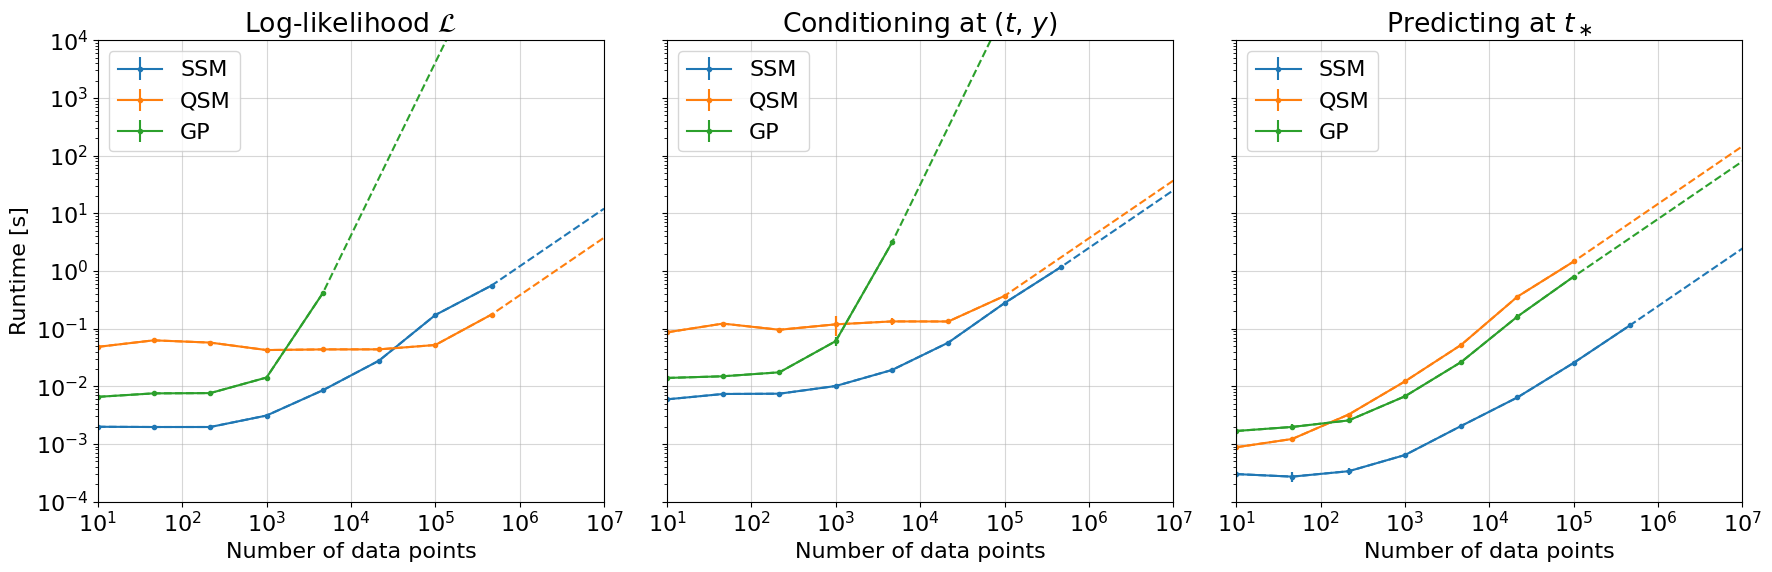

In [ ]:
savefig = '/Users/rrubenzahl/Desktop/figures/benchmark_cpu.png'

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6), sharex=True, sharey=True)

ax1 = plot_benchmark(Ns, runtime_ss_llh, runtime_qs_llh, runtime_gp_llh, 
                    ax=ax1, labels=['SSM', 'QSM', 'GP'],)# savefig=savefig)
ax1.legend(loc='upper left')
ax1.set_title('Log-likelihood $\mathcal{L}$')

ax2 = plot_benchmark(Ns, runtime_ss_cond, runtime_qs_cond, runtime_gp_cond, 
                    ax=ax2, labels=['SSM', 'QSM', 'GP'],)# savefig=savefig)
ax2.legend(loc='upper left')
ax2.set(title=r'Conditioning at ($t$, $y$)', ylabel=None)

ax3 = plot_benchmark(Ns, runtime_ss_pred, runtime_qs_pred, runtime_gp_pred, 
                    ax=ax3, labels=['SSM', 'QSM', 'GP'], powers=[1,1,1])# savefig=savefig)
ax3.legend(loc='upper left')
ax3.set(title=r'Predicting at $t_\ast$', 
        xlabel='Number of test points', ylabel=None)
ax1.set(xlim=[Ns.min(), Ns.max()], ylim=[1e-4, 1e4])
fig.tight_layout()
plt.savefig(savefig, dpi=300, bbox_inches='tight')